In [10]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import math
import sys
import os

In [11]:
# See: https://github.com/totex/PyOpenGL_tutorials/blob/master/ObjLoader.py
class ObjLoader:
    def __init__(self):
        self.vert_coords = []
        self.text_coords = []
        self.norm_coords = []
        self.vert_colors = []

        self.vertex_index = []
        self.texture_index = []
        self.normal_index = []

        self.materials = {}

        self.object = None
        self.mtllib = None
        self.usemtl = None
        self.smooth = None

    def load_material(self, file):
        matname = os.path.splitext(os.path.basename(file))[0]
        matdata = None

        class Material:
            def __init__(self, path):
                self.path = path
                self.Ns = None
                self.Ni = None
                self.Ka = None
                self.Kd = None
                self.Ks = None
                self.Ke = None
                self.d = None
                self.illum = None
                self.map_Kd = None
            def __repr__(self):
                return f"Material['{self.map_Kd}']"
            def __str__(self):
                return f"Material['{self.map_Kd}']"
            def getKdImage(self):
                return Image.open(os.path.join(os.path.dirname(self.path), self.map_Kd))

        for line in open(file, 'r'):
            if line.lstrip().startswith('#'): continue
            values = line.split()
            if not values: continue

            if values[0] == 'newmtl':
                matname = values[1]
                matdata = Material(file)
            if values[0] == 'Ns':
                matdata.Ns = values[1]
            if values[0] == 'Ni':
                matdata.Ni = values[1]
            if values[0] == 'Ka':
                matdata.Ka = values[1:4]
            if values[0] == 'Kd':
                matdata.Kd = values[1:4]
            if values[0] == 'Ks':
                matdata.Ks = values[1:4]
            if values[0] == 'Ke':
                matdata.Ke = values[1:4]
            if values[0] == 'd':
                matdata.d = values[1]
            if values[0] == 'illum':
                matdata.illum = values[1]
            if values[0] == 'map_Kd':
                matdata.map_Kd = values[1]

        self.materials[matname] = matdata

    def load_model(self, file):
        normals = False
        texture = False
        vcolors = False
        for line in open(file, 'r'):
            if line.lstrip().startswith('#'): continue
            values = line.split()
            if not values: continue

            if values[0] == 'o':
                self.object = values[1]

            if values[0] == 's':
                self.smooth = values[1]

            if values[0] == 'mtllib':
                self.mtllib = values[1]

                mtllib = os.path.join(os.path.dirname(file), values[1])
                self.load_material(mtllib)

            if values[0] == 'usemtl':
                self.usemtl = values[1]

                self.material = self.materials[values[1]]

            if values[0] == 'v':
                self.vert_coords.append([float(v) for v in values[1:4]])
                if len(values) >= 7:
                    vcolors = True
                    self.vert_colors.append(values[4:7])
            if values[0] == 'vt':
                texture = True
                self.text_coords.append([float(v) for v in values[1:3]])
            if values[0] == 'vn':
                normals = True
                self.norm_coords.append([float(v) for v in values[1:4]])

            if values[0] == 'f':
                face_i = []
                text_i = []
                norm_i = []
                for v in values[1:]:
                    w = v.split('/')
                    face_i.append(int(w[0])-1)
                    if texture:
                        text_i.append(int(w[1])-1)
                    if normals:
                        norm_i.append(int(w[2])-1)
                self.vertex_index.append([face_i])
                if texture:
                    self.texture_index.append([text_i])
                if normals:
                    self.normal_index.append([norm_i])

        self.vertex_index = [y for x in self.vertex_index for y in x]
        self.texture_index = [y for x in self.texture_index for y in x]
        self.normal_index = [y for x in self.normal_index for y in x]

        if texture:
            assert(len(self.vertex_index) == len(self.texture_index))
        if normals:
            assert(len(self.vertex_index) == len(self.normal_index))

    def calc_boundaries(self):
        min_x = float('inf')
        min_y = float('inf')
        min_z = float('inf')

        max_x = float('-inf')
        max_y = float('-inf')
        max_z = float('-inf')

        for x, y, z in self.vert_coords:
            min_x = min(min_x, float(x))
            min_y = min(min_y, float(y))
            min_z = min(min_z, float(z))

            max_x = max(max_x, float(x))
            max_y = max(max_y, float(y))
            max_z = max(max_z, float(z))

        return (min_x, min_y, min_z), (max_x, max_y, max_z)

    def print_model(self, file=sys.stderr):
        def w(*args, **kwargs):
            print(*args, file=file, **kwargs)

        if not self.mtllib is None:
            w(f"mtllib {self.mtllib}")
        if not self.object is None:
            w(f"o {self.object}")
        for v in self.vert_coords:
            w("v " + ' '.join([f"{n:.6f}" for n in v]))
        for vt in self.text_coords:
            w("vt " + ' '.join([f"{n:.4f}" for n in vt]))
        for vn in self.norm_coords:
            w("vn " + ' '.join([f"{n:.4f}" for n in vn]))
        if not self.usemtl is None:
            w(f"usemtl {self.usemtl}")
        if not self.smooth is None:
            w(f"s {self.smooth}")
        for vl, tl, nl in zip(self.vertex_index, self.texture_index, self.normal_index):
            w("f " + ' '.join([f"{vi+1}/{ti+1}/{ni+1}" for vi, ti, ni in zip(vl, tl, nl)]))


vert_coords (8)   = [[1.0, 0.0, 0.0], [1.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, 0.0], [1.0, 2.0, 0.0], [1.0, 2.0, 1.0], [0.0, 2.0, 1.0], [0.0, 2.0, 0.0]]
text_coords (20)   = [[0.0, 0.0], [0.0, 1.0], [1.0, 1.0], [1.0, 0.0], [0.0, 0.0], [0.0, 1.0], [1.0, 1.0], [1.0, 0.0], [0.0, 1.0], [1.0, 1.0], [1.0, 0.0], [0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [0.0, 0.0], [0.0, 1.0], [1.0, 1.0], [0.0, 1.0], [1.0, 1.0], [1.0, 0.0]]
norm_coords (6)   = [[0.0, -1.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [-0.0, -0.0, 1.0], [-1.0, -0.0, -0.0], [0.0, 0.0, -1.0]]
vert_colors (0)   = []
vertex_index (6)  = [[0, 1, 2, 3], [4, 7, 6, 5], [0, 4, 5, 1], [1, 5, 6, 2], [2, 6, 7, 3], [4, 0, 3, 7]]
texture_index (6) = [[0, 1, 2, 3], [4, 5, 6, 7], [0, 8, 9, 10], [11, 12, 6, 13], [14, 15, 16, 3], [4, 17, 18, 19]]
normal_index (6)  = [[0, 0, 0, 0], [1, 1, 1, 1], [2, 2, 2, 2], [3, 3, 3, 3], [4, 4, 4, 4], [5, 5, 5, 5]]


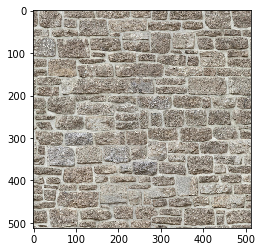

In [12]:
obj = ObjLoader()
obj.load_model("models/wall.obj")
img = obj.material.getKdImage()

print(f"vert_coords ({len(obj.vert_coords)})   = {obj.vert_coords}")
print(f"text_coords ({len(obj.text_coords)})   = {obj.text_coords}")
print(f"norm_coords ({len(obj.norm_coords)})   = {obj.norm_coords}")
print(f"vert_colors ({len(obj.vert_colors)})   = {obj.vert_colors}")
print(f"vertex_index ({len(obj.vertex_index)})  = {obj.vertex_index}")
print(f"texture_index ({len(obj.texture_index)}) = {obj.texture_index}")
print(f"normal_index ({len(obj.normal_index)})  = {obj.normal_index}")

texture_rgba = img.convert('RGBA')
plt.imshow(texture_rgba)
plt.show()

In [13]:
obj.print_model()

(min_x, min_y, min_z), (max_x, max_y, max_z) = obj.calc_boundaries()

print(min_x, min_y, min_z)
print(max_x, max_y, max_z)

0.0 0.0 0.0
1.0 2.0 1.0


mtllib wall.mtl
o Cube
v 1.000000 0.000000 0.000000
v 1.000000 0.000000 1.000000
v 0.000000 0.000000 1.000000
v 0.000000 0.000000 0.000000
v 1.000000 2.000000 0.000000
v 1.000000 2.000000 1.000000
v 0.000000 2.000000 1.000000
v 0.000000 2.000000 0.000000
vt 0.0000 0.0000
vt 0.0000 1.0000
vt 1.0000 1.0000
vt 1.0000 0.0000
vt 0.0000 0.0000
vt 0.0000 1.0000
vt 1.0000 1.0000
vt 1.0000 0.0000
vt 0.0000 1.0000
vt 1.0000 1.0000
vt 1.0000 0.0000
vt 0.0000 0.0000
vt 0.0000 1.0000
vt 1.0000 0.0000
vt 0.0000 0.0000
vt 0.0000 1.0000
vt 1.0000 1.0000
vt 0.0000 1.0000
vt 1.0000 1.0000
vt 1.0000 0.0000
vn 0.0000 -1.0000 0.0000
vn 0.0000 1.0000 0.0000
vn 1.0000 0.0000 0.0000
vn -0.0000 -0.0000 1.0000
vn -1.0000 -0.0000 -0.0000
vn 0.0000 0.0000 -1.0000
usemtl Material
s off
f 1/1/1 2/2/1 3/3/1 4/4/1
f 5/5/2 8/6/2 7/7/2 6/8/2
f 1/1/3 5/9/3 6/10/3 2/11/3
f 2/12/4 6/13/4 7/7/4 3/14/4
f 3/15/5 7/16/5 8/17/5 4/4/5
f 5/5/6 1/18/6 4/19/6 8/20/6


In [14]:
obj = ObjLoader()
obj.load_model("models/caution.obj")

(min_x, min_y, min_z), (max_x, max_y, max_z) = obj.calc_boundaries()
dif_x = max_x - min_x
dif_y = max_y - min_y
dif_z = max_z - min_z

print(min_x, min_y, min_z)
print(max_x, max_y, max_z)
print(dif_x, dif_y, dif_z)

scale_x = 1.0 / dif_x
scale_y = 2.0 / dif_y
scale_z = 1.0 / dif_z

scale = min(scale_x, scale_y, scale_z)
scale_x = scale
scale_y = scale
scale_z = scale
 
for v in obj.vert_coords:
    v[0] = (v[0] - min_x) * scale_x
    v[1] = (v[1] - min_y) * scale_y
    v[2] = (v[2] - min_z) * scale_z

(min_x, min_y, min_z), (max_x, max_y, max_z) = obj.calc_boundaries()
print(min_x, min_y, min_z)
print(max_x, max_y, max_z)

offset_x = (1.0 - max_x) / 2.0
offset_y = 0.0
offset_z = (1.0 - max_z) / 2.0

for v in obj.vert_coords:
    v[0] = v[0] + offset_x
    v[1] = v[1] + offset_y
    v[2] = v[2] + offset_z

(min_x, min_y, min_z), (max_x, max_y, max_z) = obj.calc_boundaries()
print(min_x, min_y, min_z)
print(max_x, max_y, max_z)

-0.150027 0.002169 -0.193259
0.150027 0.631713 0.16525
0.300054 0.629544 0.35850899999999997
0.0 0.0 0.0
0.8369497000075312 1.7560061253692376 1.0
0.08152514999623439 0.0 0.0
0.9184748500037656 1.7560061253692376 1.0


In [15]:
obj.print_model()

mtllib caution.mtl
v 0.081525 0.011185 1.000000
v 0.918475 0.011185 1.000000
v 0.081525 1.498941 0.613745
v 0.918475 1.498941 0.613745
v 0.308694 0.011185 1.000000
v 0.691306 0.011185 1.000000
v 0.639759 1.498941 0.613745
v 0.360241 1.498941 0.613745
v 0.081525 0.258047 0.935910
v 0.308694 0.258047 0.935910
v 0.691306 0.258047 0.935910
v 0.918475 0.258047 0.935910
v 0.186390 1.756006 0.546812
v 0.813610 1.756006 0.546812
v 0.659073 1.756006 0.546812
v 0.345530 1.756006 0.546812
v 0.143342 1.650578 0.574376
v 0.655279 1.650578 0.574376
v 0.081525 0.000000 0.956910
v 0.918475 0.000000 0.956910
v 0.081525 1.487756 0.570652
v 0.918475 1.487756 0.570652
v 0.308694 0.000000 0.956910
v 0.691306 0.000000 0.956910
v 0.639759 1.487756 0.570652
v 0.360241 1.487756 0.570652
v 0.081525 0.246859 0.892817
v 0.308694 0.246859 0.892820
v 0.691306 0.246859 0.892820
v 0.918475 0.246859 0.892820
v 0.856658 1.650578 0.574376
v 0.344718 1.650578 0.574376
v 0.655003 1.636690 0.531987
v 0.857759 1.636690 0.53